### Adapatación código GEE 


Codigo en GEE, Escrito por Pedro Rodriguez-Veiga
//Organization: National Centre for Earth Observation - University of Leiceicester (UK)
//In colaboration with: IDEAM - Institute of Hydrology, Meteorology and Environmental Studies (Colombia)
//Purpose: Development / testing Colombia's aboveground biomass map algorithm
//Current version: 4.1
//Improvements version 4.1:
//   - AGB estimated using Chave et al. and Alvarez et al. type I allometries
//   - Co-registration ALOS-2 PALSAR-2 composite to Sentinel-1
//   - The k-fold cross-validation was converted to loop functions
//   - The PPM validation is now completely independent (the corresponding conglomerados within the the same location are not used for cal/val)
//   - Error propagation on the uncertainty layer (RMSE or Rel_RMSE)

### Librerías

In [2]:
import datacube
from datacube.storage import netcdf_writer
from datacube.model import Variable, CRS
import os
import re
import xarray as xr
import numpy as np
import gdal
from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.utils.multiclass import unique_labels
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal,ogr
from glob import glob
import matplotlib as mpl


/home/cubo/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Definición de funciones

In [7]:
def exportar(fname, data, geo_transform, projection):
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None

In [3]:
def rasterizar_entrenamiento(plyr, pValFilter, pAttrFil, pAttrAGB, rows, cols , geo_transform, projection):
    labeled_pixels = np.zeros((rows, cols)) # imagen base de zeros donde empieza a llenar
    plyr.SetAttributeFilter(pAttrFil + " <> " + "'" + str(pValFilter) + "'")  #### Con este filtra
    print("Nro de Pol Filtrados  <> de",str(pValFilter),":", plyr.GetFeatureCount())
    pClasesAGB = []
    for feature in plyr:
        pClasesAGB.append(feature.GetField(pAttrAGB))
        pClasesAGB = list(dict.fromkeys(pClasesAGB)) # remueve Duplicados si hay dos o mas poligonos con el mismo AGB
    print(pClasesAGB)
  
  #driver = gdal.GetDriverByName('MEM')
   #target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    for val in pClasesAGB:
        plyr.SetAttributeFilter(pAttrAGB + " = " + str(val))  #### Con este filtra
        print("AGB:", val , "nroPol:", plyr.GetFeatureCount())
        driver = gdal.GetDriverByName('MEM')
        target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
        target_ds.SetGeoTransform(geo_transform)
        target_ds.SetProjection(projection)
        gdal.RasterizeLayer(target_ds, [1], plyr, burn_values=[val]) ## Asigna el valor de label al poligono 
      #return target_ds
        band = target_ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
    return labeled_pixels

In [69]:
def ValidarClass(plyr, pValFilter, pAttrFil, pAttrAGB, geo_transform, projection, kFoldImg):
        rows, cols = kFoldImg.shape
        labeled_pixels = np.zeros((rows, cols)) # imagen base de zeros donde empieza a llenar
        plyr.SetAttributeFilter(pAttrFil + " = " + "'" + str(pValFilter) + "'")  #### Con este filtra
        print("Nro Poligonos para el Kfold", str(pValFilter), " = ", plyr.GetFeatureCount())
        pClasesAGB = []
        for feature in plyr:
             pClasesAGB.append(feature.GetField(pAttrAGB))
        pClasesAGB = list(dict.fromkeys(pClasesAGB)) # remueve Duplicados si hay dos o mas poligonos con el mismo AGB
        for val in pClasesAGB:
            plyr.SetAttributeFilter(pAttrAGB + " = " + str(val))  #### Con este filtra
            print("AGB:", val , "nroPol:", plyr.GetFeatureCount())
            driver = gdal.GetDriverByName('MEM')
            target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
            target_ds.SetGeoTransform(geo_transform)
            target_ds.SetProjection(projection)
            gdal.RasterizeLayer(target_ds, [1], plyr, burn_values=[val]) ## Asigna el valor de label al poligono 
            band = target_ds.GetRasterBand(1)
            ### Valida el poligono contra los datos del shape
            pImgPol = np.array(band.ReadAsArray())
            pClassImaKfold = np.array(kFoldImg)
            n_samples = rows*cols
            imagRes = np.where(pImgPol.reshape((n_samples, 1)) > 0, pClassImaKfold.reshape((n_samples, 1)), 0) 
            print("AGB en Shp: ", str(val),"Media Calculada:", np.mean(imagRes[imagRes != 0]))
            labeled_pixels += imagRes.reshape((rows, cols))
        return labeled_pixels


### Definción de Consulta

#### Parámetros de Consulta

In [8]:
execID=1
algorithm = "RandomForestReg"
version= "1.0"

##### Los parametros que encontrará a continuación corresponde 

- products = Unidad de almacenamiento que desea consultar (Sátelite), Landsat 5, 7 y 8 
- bands = Las bandas que desea emplear para el calculo de medianas y los índices que encontrará debajo  de la función de medianas
- time_ranges = Rango o periodo de tiempo a cosultar (Veriricar que corresponda a los datos disponibles por unidad de almacenamiento)
- Área = El usuario debe definir la longitud mínima, máxima y la latitud mínima, máxima del área de consulta
- normalized = Función para normalizar los valores resultantes del cálculo de las medianas
- minValid = Valor mínimo valido que empleará el algoritmo  para el cálculo de las medianas
- nodata= -9999 Es el valor por defecto que se dará a los valores no data en el cálculo de las medianas

In [10]:
products = ['LS8_OLI_LASRC'] #Productos sobre los que se hará la consulta (unidades de almacenamiento)
bands=["red","nir", "swir1","swir2","green","blue"] #arreglo de bandas #"blue","green",
time_ranges = [("2016-01-01", "2016-02-25")] #Una lista de tuplas, cada tupla representa un periodo
#área sobre la cual se hará la consulta:
min_long = -73
min_lat = 11
max_long = -71
max_lat = 12

In [11]:
normalized=True
minValid=1;

nodata=-9999

In [12]:
dc = datacube.Datacube(app="{}_{}_{}".format(algorithm,version,execID))

#### Función de Consulta de unidad de almacenamiento Landsat con parámetros asignados

In [16]:
kwargs={}
dc = datacube.Datacube(app="{}_{}_{}".format(algorithm,version,execID))
for product in products:
    i=0
    validValues=set()
    if product=="LS7_ETM_LEDAPS":
        validValues=[66,68,130,132]
    elif product == "LS8_OLI_LASRC":
        validValues=[322, 386, 834, 898, 1346, 324, 388, 836, 900, 1348]
    for tr in time_ranges:
        _data = dc.load(product=product, longitude=(min_long, max_long), latitude=(min_lat, max_lat), time=tr)
        if len(_data.data_vars)==0:
            break
        cloud_mask=np.isin(_data["pixel_qa"].values, validValues)
        for band in bands:
            _data[band].values=np.where(np.logical_and(_data.data_vars[band]!=nodata,cloud_mask),_data.data_vars[band], np.nan)
        _undesired=list(set(_data.keys())-set(bands+['latitude','longitude','time']))
        _data=_data.drop(_undesired)
            
        if "xarr"+str(i) in kwargs:
            kwargs["xarr"+str(i)]=xr.concat([kwargs["xarr"+str(i)],_data.copy(deep=True)], 'time')
        else:
            kwargs["xarr"+str(i)]=_data
    i+=1
del _data

/home/cubo/anaconda/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


In [17]:
#El algoritmo recibe los productos como xarrays en variablles llamadas xarr0, xarr1, xarr2... 
xarr0=kwargs["xarr0"]
del kwargs

#### Función de Consulta de unidad de almacenamiento Radar ALOS PALSAR con parámetros asignados


In [23]:
_data3 = dc.load(product="ALOS2_PALSAR_MOSAIC", longitude=(min_long, max_long), latitude=(min_lat, max_lat), time=("2016-01-01", "2016-12-31"))

In [24]:
xarr0['hh']=_data3['hh']
xarr0['hv']=_data3['hv']

#### Función de Cálculo de Índices para unidad de alamacenamiento RADAR ALOS PALSAR

In [26]:
banda1=_data3['hh']
banda2=_data3['hv']

In [27]:
#CÁLCULO DE 1ER ÍNDICE RDFI
RDFI =(banda1-banda2)/(banda1+banda2)

In [28]:
#CÁLCULO DE 2DO ÍNDICE SPR
s1  = (banda1+banda2)
s2  =(banda1-banda2)
s3 = 2 * (banda1 **(1/2))*(banda2 **(1/2)) * np.cos(banda1-banda2)
s4 =2 * (banda1 **(1/2))*(banda2 **(1/2)) * np.sin(banda1-banda2)
LPR =(s1+s2)/(s1-s2)
SC = 0.5*s1 - 0.5 * s4
OC = 0.5*s1 + 0.5 * s4
CPR =(SC/OC)
m = (((s2**2)+(s3**2)+(s4**2))**(1/2))/s1

#### Función cálculo de medianas de la consulta anterior 

In [18]:
medians={} 
for band in bands:
    datos=xarr0[band].values
    allNan=~np.isnan(datos) #Una mascara que indica qué datos son o no nan. 
    if normalized: #Normalizar, si es necesario.
        #Para cada momento en el tiempo obtener el promedio y la desviación estándar de los valores de reflectancia
        m=np.nanmean(datos.reshape((datos.shape[0],-1)), axis=1)
        st=np.nanstd(datos.reshape((datos.shape[0],-1)), axis=1)
        # usar ((x-x̄)/st) para llevar la distribución a media 0 y desviación estándar 1, 
        # y luego hacer un cambio de espacio para la nueva desviación y media. 
        datos=np.true_divide((datos-m[:,np.newaxis,np.newaxis]), st[:,np.newaxis,np.newaxis])*np.nanmean(st)+np.nanmean(m)
    #Calcular la mediana en la dimensión de tiempo 
    medians[band]=np.nanmedian(datos,0) 
    #Eliminar los valores que no cumplen con el número mínimo de pixeles válidos dado. 
    medians[band][np.sum(allNan,0)<minValid]=np.nan
    
del datos

/home/cubo/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [19]:
# Dimensiones de filas y columnas que empleará el algoritmo para definir su salida final
rows, cols = medians[bands[0]].shape

#### Cálculo de índices a partir de la consulta de medianas realizada anteriormente

In [30]:
medians["ndvi"]=(medians["nir"]-medians["red"])/(medians["nir"]+medians["red"])

In [31]:
medians["ndmi"]=(medians["nir"]-medians["swir1"])/(medians["nir"]+medians["swir1"])

In [32]:
medians["nbr"]=(medians["nir"]-medians["swir2"])/(medians["nir"]+medians["swir2"])

In [33]:
medians["nbr2"]=(medians["swir1"]-medians["swir2"])/(medians["swir1"]+medians["swir2"])

In [34]:
medians["savi"]=(medians["nir"]-medians["red"])/(medians["nir"]+medians["red"]+1)*2 

In [35]:
medians['rdfi']=RDFI[0].values

In [36]:
medians['cpR']=CPR[0].values

In [37]:
medians['hh']=banda1[0].values

In [38]:
medians['hv']=banda2[0].values

In [39]:
#Lista de bandas del arreglo cálculado 
bands=list(medians.keys())
bands

['red',
 'nir',
 'swir1',
 'swir2',
 'green',
 'blue',
 'ndvi',
 'ndmi',
 'nbr',
 'nbr2',
 'savi',
 'rdfi',
 'cpR',
 'hh',
 'hv']

In [40]:
#Registro de sistema de referencia y coordenadas del arreglo que posteriormente el algoritmo emplea en la salida
_coords=xarr0.coords
_crs=xarr0.crs

In [41]:
#Registro de sistema de referencia y coordenadas del arreglo que posteriormente el algoritmo emplea en la salida
geo_transform=(_coords["longitude"].values[0], 0.000269995,0, _coords["latitude"].values[0],0,-0.000271302)
proj=_crs.wkt

### Clasificación y regresión de Random Forest


#### Prepara insumos vector

In [3]:
shapeFileCorte = r'/home/cubo/jupyter/Biomasa/ipcc/Conglomerados.shp'
ds=ogr.Open(shapeFileCorte)
lyr=ds.GetLayer()
print(lyr)
##Dentro de la función de rasterización de los valores de AGB cálculado por chavez se asigna al campo "pAttrAGB" la columna correspondiente dentro del shapefile para el ejemplo corresponde a "cha_HD"
##para la discriminación de valores por kfold se deberá asignar el attributo "pAttributo" que dentro del shapefile contiene el valor de kfold para cada poligono para el ejemplo es "k10"
pAttributo = 'K10'
pAttrAGB = 'cha_HD'
print("Nro poligonos en Shape:",lyr.GetFeatureCount())
pClasesName = []
       #lee todos los poligonos para extraer el numero de clases en el arreglo 
for feature in lyr:
    pClasesName.append(feature.GetField(pAttributo))
    pClasesName = list(dict.fromkeys(pClasesName)) # remueve Duplicados
print(pClasesName)
proj='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'


<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x7f115084c930> >
Nro poligonos en Shape: 9
[7.0, 1.0, 9.0, 5.0, 6.0, 2.0, 10.0]


In [45]:
pClasesName

[7.0, 1.0, 9.0, 5.0, 6.0, 2.0, 10.0]

In [46]:
###Se procede a realizar  la rasterización de los poligonos ingresados definidos con los parámetros anteriormente
ImagesTrain = []
for K in pClasesName: # Recorre los ipcc o Kfold
    pima = rasterizar_entrenamiento(lyr, K, pAttributo, pAttrAGB, rows, cols, geo_transform, proj) #rasteriza todos menos el kfold
    print(pima.max())
    ImagesTrain.append(pima)
        ##############   con la imagen rasterizada se realiza clasificacion en esta parte del codigo para cada uno de los K-fold   ##################
    

Nro de Pol Filtrados  <> de 7.0 : 6
[12.3532, 2.28068, 10.8896, 6.44028, 6.48006, 5.95838]
AGB: 12.3532 nroPol: 1
AGB: 2.28068 nroPol: 1
AGB: 10.8896 nroPol: 1
AGB: 6.44028 nroPol: 1
AGB: 6.48006 nroPol: 1
AGB: 5.95838 nroPol: 1
12.0
Nro de Pol Filtrados  <> de 1.0 : 8
[4.34956, 13.6518, 2.28068, 10.8896, 6.44028, 6.48006, 5.95838, 4.44512]
AGB: 4.34956 nroPol: 1
AGB: 13.6518 nroPol: 1
AGB: 2.28068 nroPol: 1
AGB: 10.8896 nroPol: 1
AGB: 6.44028 nroPol: 1
AGB: 6.48006 nroPol: 1
AGB: 5.95838 nroPol: 1
AGB: 4.44512 nroPol: 1
14.0
Nro de Pol Filtrados  <> de 9.0 : 8
[4.34956, 13.6518, 12.3532, 10.8896, 6.44028, 6.48006, 5.95838, 4.44512]
AGB: 4.34956 nroPol: 1
AGB: 13.6518 nroPol: 1
AGB: 12.3532 nroPol: 1
AGB: 10.8896 nroPol: 1
AGB: 6.44028 nroPol: 1
AGB: 6.48006 nroPol: 1
AGB: 5.95838 nroPol: 1
AGB: 4.44512 nroPol: 1
14.0
Nro de Pol Filtrados  <> de 5.0 : 8
[4.34956, 13.6518, 12.3532, 2.28068, 6.44028, 6.48006, 5.95838, 4.44512]
AGB: 4.34956 nroPol: 1
AGB: 13.6518 nroPol: 1
AGB: 12.3532 nr

In [47]:
ImagesTrain[0].max()

12.0

imagen ipcc 10


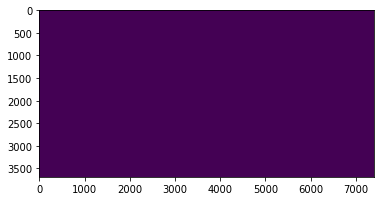

In [50]:
## Ploteo de poligonos rasterizados
print("imagen ipcc 10")
plt.imshow(ImagesTrain[1]);# muestra la ultima ejecucióm

## Itera las clasificaciones de los K-Fold y las guarda en un arreglo (kClasificaciones)

In [52]:
start = datetime.datetime.now()  
print ('Comenzando Clasificacion: %s\n' % (start) )

kClasificaciones = []
# Parametros de la clasificación definidos para  la función Random Forest Regressor
maxDepth=2
RandState=0
NroEstimator=10

Comenzando Clasificacion: 2019-11-19 11:27:39.381306



In [53]:
for i in range(0,len(ImagesTrain)):
    print("Clasificando K-fold", i+1)
    labeled_pixels=ImagesTrain[i]
    is_train = np.nonzero(labeled_pixels)
    training_labels = labeled_pixels[is_train]
    bands_data=[]
    for band in bands: 
        bands_data.append(medians[band])
    bands_data = np.dstack(bands_data)
    print("bands_data")
    print(bands_data)
    training_samples = bands_data[is_train]
    np.isfinite(training_samples)
    _msk=np.sum(np.isfinite(training_samples),1)>1
    training_samples= training_samples[_msk,:]
    training_labels=training_labels[_msk]
    #asignación de mascara valores nan por valor no data
    mask_nan=np.isnan(training_samples)
    training_samples[mask_nan]=-9999
    ##Clasificación RF por regresión con los parametros definidos anteriormente
    classifier = RandomForestRegressor(max_depth= maxDepth, random_state=RandState,   n_estimators=NroEstimator)
    classifier.fit(training_samples, training_labels)
    rows, cols, n_bands = bands_data.shape
    n_samples = rows*cols
    flat_pixels = bands_data.reshape((n_samples, n_bands))
    #asignación de mascara valores nan por valor no data=-9999
    mask_nan=np.isnan(flat_pixels)
    flat_pixels[mask_nan]=-9999
    flat_pixels = bands_data.reshape((n_samples, n_bands))
    ##preparación de resultados en matriz con dimensiones igual a las consultadas al principio del código
    result = classifier.predict(flat_pixels)
    classification = result.reshape((rows, cols))
    kClasificaciones.append(classification)

Clasificando K-fold 1
bands_data
[[[3.47689856e+02 5.52354543e+02 3.71775865e+02 ... 1.64504736e+00
   2.40700000e+03 5.50000000e+02]
  [3.43309003e+02 5.45629778e+02 3.68422305e+02 ... 6.03425180e+00
   2.32900000e+03 5.52000000e+02]
  [3.39804321e+02 5.48992161e+02 3.69260695e+02 ... 1.16448891e+00
   2.16100000e+03 4.99000000e+02]
  ...
  [3.07792328e+02 1.17863451e+03 1.11606190e+03 ... 1.61373718e+00
   2.40100000e+03 6.42000000e+02]
  [3.16657924e+02 1.17718234e+03 1.11606190e+03 ... 4.20345612e-01
   2.11300000e+03 5.71000000e+02]
  [3.19329631e+02 1.18008667e+03 1.12101250e+03 ... 3.02858496e-01
   2.42800000e+03 6.68000000e+02]]

 [[3.47689856e+02 5.57398116e+02 3.75129426e+02 ... 4.06378108e+00
   2.26500000e+03 5.38000000e+02]
  [3.39804321e+02 5.44789183e+02 3.68422305e+02 ... 4.23126285e-01
   2.22800000e+03 5.31000000e+02]
  [3.37175809e+02 5.53195138e+02 3.70099085e+02 ... 3.28728215e-01
   2.36900000e+03 5.57000000e+02]
  ...
  [3.05080525e+02 1.17282585e+03 1.11818359e

Clasificando K-fold 4
bands_data
[[[3.47689856e+02 5.52354543e+02 3.71775865e+02 ... 1.64504736e+00
   2.40700000e+03 5.50000000e+02]
  [3.43309003e+02 5.45629778e+02 3.68422305e+02 ... 6.03425180e+00
   2.32900000e+03 5.52000000e+02]
  [3.39804321e+02 5.48992161e+02 3.69260695e+02 ... 1.16448891e+00
   2.16100000e+03 4.99000000e+02]
  ...
  [3.07792328e+02 1.17863451e+03 1.11606190e+03 ... 1.61373718e+00
   2.40100000e+03 6.42000000e+02]
  [3.16657924e+02 1.17718234e+03 1.11606190e+03 ... 4.20345612e-01
   2.11300000e+03 5.71000000e+02]
  [3.19329631e+02 1.18008667e+03 1.12101250e+03 ... 3.02858496e-01
   2.42800000e+03 6.68000000e+02]]

 [[3.47689856e+02 5.57398116e+02 3.75129426e+02 ... 4.06378108e+00
   2.26500000e+03 5.38000000e+02]
  [3.39804321e+02 5.44789183e+02 3.68422305e+02 ... 4.23126285e-01
   2.22800000e+03 5.31000000e+02]
  [3.37175809e+02 5.53195138e+02 3.70099085e+02 ... 3.28728215e-01
   2.36900000e+03 5.57000000e+02]
  ...
  [3.05080525e+02 1.17282585e+03 1.11818359e

Clasificando K-fold 7
bands_data
[[[3.47689856e+02 5.52354543e+02 3.71775865e+02 ... 1.64504736e+00
   2.40700000e+03 5.50000000e+02]
  [3.43309003e+02 5.45629778e+02 3.68422305e+02 ... 6.03425180e+00
   2.32900000e+03 5.52000000e+02]
  [3.39804321e+02 5.48992161e+02 3.69260695e+02 ... 1.16448891e+00
   2.16100000e+03 4.99000000e+02]
  ...
  [3.07792328e+02 1.17863451e+03 1.11606190e+03 ... 1.61373718e+00
   2.40100000e+03 6.42000000e+02]
  [3.16657924e+02 1.17718234e+03 1.11606190e+03 ... 4.20345612e-01
   2.11300000e+03 5.71000000e+02]
  [3.19329631e+02 1.18008667e+03 1.12101250e+03 ... 3.02858496e-01
   2.42800000e+03 6.68000000e+02]]

 [[3.47689856e+02 5.57398116e+02 3.75129426e+02 ... 4.06378108e+00
   2.26500000e+03 5.38000000e+02]
  [3.39804321e+02 5.44789183e+02 3.68422305e+02 ... 4.23126285e-01
   2.22800000e+03 5.31000000e+02]
  [3.37175809e+02 5.53195138e+02 3.70099085e+02 ... 3.28728215e-01
   2.36900000e+03 5.57000000e+02]
  ...
  [3.05080525e+02 1.17282585e+03 1.11818359e

### Preparación de la salida de medianas resultante de la clasificación 


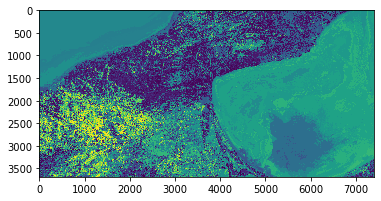

In [54]:
##Preparación de salida final 
kClasificaciones=np.asarray(kClasificaciones)
ImgResultado = np.zeros((rows, cols))
#Recorrer la matriz pixel a pixel
for l in range(0,cols):
    for j in range(0,rows): 
        dato = kClasificaciones[:,j,l]
        ## Cálculo de percentil 5 y 95 de los datos resultantes de cada set de datos correspondientes con las 7 clasificaciones anteriore resultantes, calculado pixel a pixel
        percent=np.percentile(dato,q=[5,95])
        #Cálculo de mediana para set de datos extrayendo los valores que se encuentre <5 y > 95 de los valores correspondientes a percentil, generando un solo pixel resultante.
        datoFinal = np.median(dato[np.logical_and(dato>percent[0],dato<percent[1])])
        ImgResultado[j,l]; = datoFinal

plt.imshow(ImgResultado)


In [ ]:
ImgResultado

### Validación de resultados optenidos de la clasificación 

In [70]:
ImagesVal1 = []
k=10
pContKfold = 0
for K in pClasesName: # Recorre los ipcc o Kfold
    valid = ValidarClass(lyr, K, pAttributo, pAttrAGB, geo_transform, proj, kClasificaciones[pContKfold]) #rasteriza todos menos el kfold
    ImagesVal1.append(valid)
    k=k+1
    pContKfold += 1
    print(k)

Nro Poligonos para el Kfold 7.0  =  3
AGB: 4.34956 nroPol: 1
AGB en Shp:  4.34956 Media Calculada: 11.379999999999999
AGB: 13.6518 nroPol: 1
AGB en Shp:  13.6518 Media Calculada: 11.200000000000001
AGB: 4.44512 nroPol: 1
AGB en Shp:  4.44512 Media Calculada: 5.446293718080604
11
Nro Poligonos para el Kfold 1.0  =  1
AGB: 12.3532 nroPol: 1
AGB en Shp:  12.3532 Media Calculada: 4.332400091342035
12
Nro Poligonos para el Kfold 9.0  =  1
AGB: 2.28068 nroPol: 1
AGB en Shp:  2.28068 Media Calculada: 6.602501495573169
13
Nro Poligonos para el Kfold 5.0  =  1
AGB: 10.8896 nroPol: 1
AGB en Shp:  10.8896 Media Calculada: 6.844997272775392
14
Nro Poligonos para el Kfold 6.0  =  1
AGB: 6.44028 nroPol: 1
AGB en Shp:  6.44028 Media Calculada: 5.811351023611715
15
Nro Poligonos para el Kfold 2.0  =  1
AGB: 6.48006 nroPol: 1
AGB en Shp:  6.48006 Media Calculada: 4.825321414925288
16
Nro Poligonos para el Kfold 10.0  =  1
AGB: 5.95838 nroPol: 1
AGB en Shp:  5.95838 Media Calculada: 6.667532203707461
17

### Preparar salida 

In [55]:
##Se llamará la función exportar por lo tanto deberá cambiar el nombre de manera que el algoritmo no sobr eescriba archivos con este nombre
exportar("salida_test3.tiff", ImgResultado, geo_transform, proj)